In [23]:
# Following instructions here: https://alleninstitute.github.io/openscope_databook/basics/download_nwb.html
#run using openscope environment

In [1]:
import warnings
warnings.filterwarnings('ignore')

try:
    from databook_utils.dandi_utils import dandi_stream_open
except:
    !git clone https://github.com/AllenInstitute/openscope_databook.git
    %cd openscope_databook
    %pip install -e .

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np


import os, glob
from pathlib import Path

from dandi import dandiapi
from pynwb import NWBHDF5IO
from dandi.dandiapi import DandiAPIClient
from nwbwidgets.view import default_neurodata_vis_spec
from dotenv import load_dotenv

import pynwb
from nwbwidgets import nwb2widget


from typing import Union, Iterator, Callable, Tuple, Dict
import os
from pathlib import Path
from tqdm.notebook import tqdm

%matplotlib inline

In [3]:
# define functions to download files with a progress bar

MAX_CHUNK_SIZE = int(os.environ.get("DANDI_MAX_CHUNK_SIZE", 1024 * 1024 * 8))  

def get_download_file_iter_with_steps(
    file, chunk_size: int = MAX_CHUNK_SIZE
) -> Tuple[Callable[[int], Iterator[bytes]], Dict[str, int]]:

    url = file.base_download_url
    steps_dict = {"total_steps": None}
    result = file.client.session.get(url, stream=True)

    total_size = int(result.headers.get('content-length', 0))
    steps_dict["total_steps"] = total_size // chunk_size
    print(f"Downloading {total_size} bytes in {steps_dict['total_steps']} steps")

    def downloader(start_at: int = 0) -> Iterator[bytes]:
        headers = None
        if start_at > 0:
            headers = {"Range": f"bytes={start_at}-"}
        result = file.client.session.get(url, stream=True, headers=headers)
        result.raise_for_status()
        for chunk in result.iter_content(chunk_size=chunk_size):
            if chunk:  
                yield chunk

    return downloader, steps_dict

def download_with_progressbar(
    file, filepath: Union[str, Path], chunk_size: int = MAX_CHUNK_SIZE
) -> None:
    downloader, steps_dict = get_download_file_iter_with_steps(file)
    with open(filepath, "wb") as fp:
        for chunk in tqdm(downloader(0), total=steps_dict["total_steps"], unit="chunk", unit_scale=True, unit_divisor=1024):
            fp.write(chunk)

# Testing: Average Receptive Field Across Probes

In [4]:
# load config file
load_dotenv(dotenv_path="config.env")

download_loc = os.getenv("SAMPLE_DATA_DIR")
print(download_loc)

/Users/ilmal/lab/OpenScope


In [5]:
dandiset_id = "000021"
dandi_filepath = "sub-699733573/sub-699733573_ses-715093703.nwb"

dandi_api_key = None
authenticate = False


if authenticate:
    client = dandiapi.DandiAPIClient(token=dandi_api_key)
else:
    client = dandiapi.DandiAPIClient()
my_dandiset = client.get_dandiset(dandiset_id,"draft")

print(f"Got dandiset {my_dandiset}")

filename = dandi_filepath.split("/")[-1]
filepath = f"{download_loc}\{filename}" if os.name == 'nt' else f"{download_loc}/{filename}"
print(filepath)

file = my_dandiset.get_asset_by_path(dandi_filepath)
# this may take awhile, especially if the file to download is large
download_with_progressbar(file, filepath)

print(f"Downloaded file to {filepath}")

Got dandiset DANDI:000021/draft
/Users/ilmal/lab/OpenScope/sub-699733573_ses-715093703.nwb


  0%|          | 0.00/340 [00:00<?, ?chunk/s]

Downloaded file to /Users/ilmal/lab/OpenScope/sub-699733573_ses-715093703.nwb


## Open and Display the NWB file

In [6]:
# open the downloaded NWB file
ROOT_DIR = download_loc

# Look for the first NWB file under the dandiset folder
candidates = glob.glob(str(Path(ROOT_DIR) / "**" / "*.nwb"), recursive=True)
if not candidates:
    raise FileNotFoundError("No .nwb file found under " + ROOT_DIR)
nwb_path = candidates[0]
print("Opening:", nwb_path)
io = NWBHDF5IO(nwb_path, "r", load_namespaces=True)


Opening: /Users/ilmal/lab/OpenScope/000021\sub-699733573_ses-715093703.nwb


In [7]:
nwb = io.read()
print(nwb)

units = nwb.units


root pynwb.file.NWBFile at 0x13081752432
Fields:
  acquisition: {
    raw_running_wheel_rotation <class 'pynwb.base.TimeSeries'>,
    running_wheel_signal_voltage <class 'pynwb.base.TimeSeries'>,
    running_wheel_supply_voltage <class 'pynwb.base.TimeSeries'>
  }
  devices: {
    probeA <class 'abc.EcephysProbe'>,
    probeB <class 'abc.EcephysProbe'>,
    probeC <class 'abc.EcephysProbe'>,
    probeD <class 'abc.EcephysProbe'>,
    probeE <class 'abc.EcephysProbe'>,
    probeF <class 'abc.EcephysProbe'>
  }
  electrode_groups: {
    probeA <class 'abc.EcephysElectrodeGroup'>,
    probeB <class 'abc.EcephysElectrodeGroup'>,
    probeC <class 'abc.EcephysElectrodeGroup'>,
    probeD <class 'abc.EcephysElectrodeGroup'>,
    probeE <class 'abc.EcephysElectrodeGroup'>,
    probeF <class 'abc.EcephysElectrodeGroup'>
  }
  electrodes: electrodes <class 'hdmf.common.table.DynamicTable'>
  file_create_date: [datetime.datetime(2020, 5, 26, 0, 53, 26, 986608, tzinfo=tzoffset(None, -25200))]
  i

In [8]:
rf_stim_table = nwb.intervals["gabors_presentations"].to_dataframe()
rf_stim_table[:10]

,start_time,stop_time,stimulus_name,stimulus_block,temporal_frequency,x_position,y_position,color,mask,opacity,phase,size,units,stimulus_index,orientation,spatial_frequency,contrast,tags,timeseries
id,,,,,,,,,,,,,,,,,,,
0,73.537433,73.770952,gabors,0.0,4.0,0.0,30.0,"[1.0, 1.0, 1.0]",circle,1.0,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",deg,0.0,45.0,0.08,0.8,[stimulus_time_interval],"[(1, 1, timestamps pynwb.base.TimeSeries at 0x..."
1,73.770952,74.021150,gabors,0.0,4.0,-30.0,-10.0,"[1.0, 1.0, 1.0]",circle,1.0,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",deg,0.0,0.0,0.08,0.8,[stimulus_time_interval],"[(2, 1, timestamps pynwb.base.TimeSeries at 0x..."
2,74.021150,74.271349,gabors,0.0,4.0,10.0,20.0,"[1.0, 1.0, 1.0]",circle,1.0,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",deg,0.0,45.0,0.08,0.8,[stimulus_time_interval],"[(3, 1, timestamps pynwb.base.TimeSeries at 0x..."
3,74.271349,74.521547,gabors,0.0,4.0,-40.0,-40.0,"[1.0, 1.0, 1.0]",circle,1.0,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",deg,0.0,0.0,0.08,0.8,[stimulus_time_interval],"[(4, 1, timestamps pynwb.base.TimeSeries at 0x..."
4,74.521547,74.771764,gabors,0.0,4.0,-10.0,-10.0,"[1.0, 1.0, 1.0]",circle,1.0,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",deg,0.0,90.0,0.08,0.8,[stimulus_time_interval],"[(5, 1, timestamps pynwb.base.TimeSeries at 0x..."
5,74.771764,75.021980,gabors,0.0,4.0,-30.0,-20.0,"[1.0, 1.0, 1.0]",circle,1.0,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",deg,0.0,90.0,0.08,0.8,[stimulus_time_interval],"[(6, 1, timestamps pynwb.base.TimeSeries at 0x..."
6,75.021980,75.272197,gabors,0.0,4.0,0.0,-10.0,"[1.0, 1.0, 1.0]",circle,1.0,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",deg,0.0,0.0,0.08,0.8,[stimulus_time_interval],"[(7, 1, timestamps pynwb.base.TimeSeries at 0x..."
7,75.272197,75.522413,gabors,0.0,4.0,40.0,-20.0,"[1.0, 1.0, 1.0]",circle,1.0,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",deg,0.0,0.0,0.08,0.8,[stimulus_time_interval],"[(8, 1, timestamps pynwb.base.TimeSeries at 0x..."
8,75.522413,75.772614,gabors,0.0,4.0,0.0,-20.0,"[1.0, 1.0, 1.0]",circle,1.0,"[3644.93333333, 3644.93333333]","[20.0, 20.0]",deg,0.0,90.0,0.08,0.8,[stimulus_time_interval],"[(9, 1, timestamps pynwb.base.TimeSeries at 0x..."


Opening another nwb file: 

In [9]:
# nwb_path = r"C:\Users\MaryBeth\projects\SarvestaniLab\OpenScopeMouseV1\001568\sub-810531\sub-810531_ses-ecephys-810531-2025-09-17-15-14-30_ecephys.nwb"

# io = NWBHDF5IO(nwb_path, "r", load_namespaces=True)
# nwb = io.read()

# print(nwb)
            
# units = nwb.units
# units.colnames
# nwb.intervals.keys()
# channel_probes = {nwb.electrodes["id"][i]: nwb.electrodes["group_name"][i] for i in range(len(nwb.electrodes))}

# # function retrieves peak channel ID from "units" dataset, looks up corresponding group name, returns probe associated with peak channel
# def get_unit_probe(unit_idx):
#     return str(units['device_name'][unit_idx])

# print(set(channel_probes.values()))

In [10]:
## Retrieve probe names
channel_probes = {nwb.electrodes["id"][i]: nwb.electrodes["group_name"][i] for i in range(len(nwb.electrodes))}

# function retrieves peak channel ID from "units" dataset, looks up corresponding group name, returns probe associated with peak channel
def get_unit_probe(unit_idx):
    peak_channel_id = units["peak_channel_id"][unit_idx]
    return channel_probes[peak_channel_id]

print(set(channel_probes.values()))
## Get units from selected probe & their receptive fields
### helper functions made from electrodes table to get brain location of unit or probe name of unit

# map channel ids to brain location and probe group name
# creates a dictionary that iterates over indices of the dataset, assigns "id" as the key, and makes the location the value
channel_locations = {nwb.electrodes["id"][i]: nwb.electrodes["location"][i] for i in range(len(nwb.electrodes))}
# creates similar dictionary as previous line, but with the group name/probe name as the value
channel_probes = {nwb.electrodes["id"][i]: nwb.electrodes["group_name"][i] for i in range(len(nwb.electrodes))}

# function retrieves peak channel ID for given unit index from "units" dataset and looks up corresponding probe from dictionary
def get_unit_location(unit_idx):
    peak_channel_id = units["peak_channel_id"][unit_idx]
    return channel_locations[peak_channel_id]

# function retrieves peak channel ID from "units" dataset, looks up corresponding group name, returns probe associated with peak channel
def get_unit_probe(unit_idx):
    peak_channel_id = units["peak_channel_id"][unit_idx]
    return channel_probes[peak_channel_id]

print(set(channel_locations.values()))
print(set(channel_probes.values()))

{'probeE', 'probeD', 'probeB', 'probeA', 'probeC', 'probeF'}
{'', 'VISrl', 'VISpm', 'CA3', 'LP', 'VISl', 'APN', 'VISp', 'PO', 'LGd', 'PoT', 'MB', 'CA1', 'DG', 'grey', 'VISam'}
{'probeE', 'probeD', 'probeB', 'probeA', 'probeC', 'probeF'}


In [11]:
def select_condition(unit_idx, probe, all_units=False):
    # the values below are recommended thresholds for these quality metrics
    if all_units:
        return True
    return units["snr"][unit_idx] > 1 and \
            get_unit_probe(unit_idx) == probe 

selected_unit_idxs = []
for unit_idx in range(len(units)):
    if select_condition(unit_idx, "probeB"):
        selected_unit_idxs.append(unit_idx)
        
if len(selected_unit_idxs) == 0:
    raise IndexError("There are no units for this selection")

print(len(selected_unit_idxs))

479


In [12]:
print(rf_stim_table.columns.tolist())

['start_time', 'stop_time', 'stimulus_name', 'stimulus_block', 'temporal_frequency', 'x_position', 'y_position', 'color', 'mask', 'opacity', 'phase', 'size', 'units', 'stimulus_index', 'orientation', 'spatial_frequency', 'contrast', 'tags', 'timeseries']


In [13]:
### get x and y coordinates of gabors displayed to build receptive field

xs = np.sort(list(set(rf_stim_table.x_position)))
ys = np.sort(list(set(rf_stim_table.y_position)))
field_units = rf_stim_table.units[0]
print(xs)
print(ys)
print(field_units)


### get receptive field of a unit using its spike times and the stim table

def get_rf(spike_times):
    # creates 2D array that stores response spike counts for each coordinate of the receptive field
    unit_rf = np.zeros([ys.size, xs.size])
    # for every x and y coordinate in the field
    for xi, x in enumerate(xs):
        for yi, y in enumerate(ys):
            
            # for this coordinate of the rf, count all the times that this neuron responds to a stimulus time with a spike
            stim_times = rf_stim_table[(rf_stim_table.x_position == x) & (rf_stim_table.y_position == y)].start_time
            response_spike_count = 0
            for stim_time in stim_times:
                # any spike within 0.2 seconds after stim time is considered a response
                start_idx, end_idx = np.searchsorted(spike_times, [stim_time, stim_time+0.2])
                response_spike_count += end_idx-start_idx

            unit_rf[yi, xi] = response_spike_count

    return unit_rf
    

[-40. -30. -20. -10.   0.  10.  20.  30.  40.]
[-40. -30. -20. -10.   0.  10.  20.  30.  40.]
deg


In [ ]:
### compute receptive fields for each unit in selected units

unit_rfs = []
for unit_idx in selected_unit_idxs:
    unit_spike_times = units["spike_times"][unit_idx]
    unit_rfs.append(get_rf(unit_spike_times))

#print(unit_rfs)
#print(type(unit_rfs))

<class 'list'>


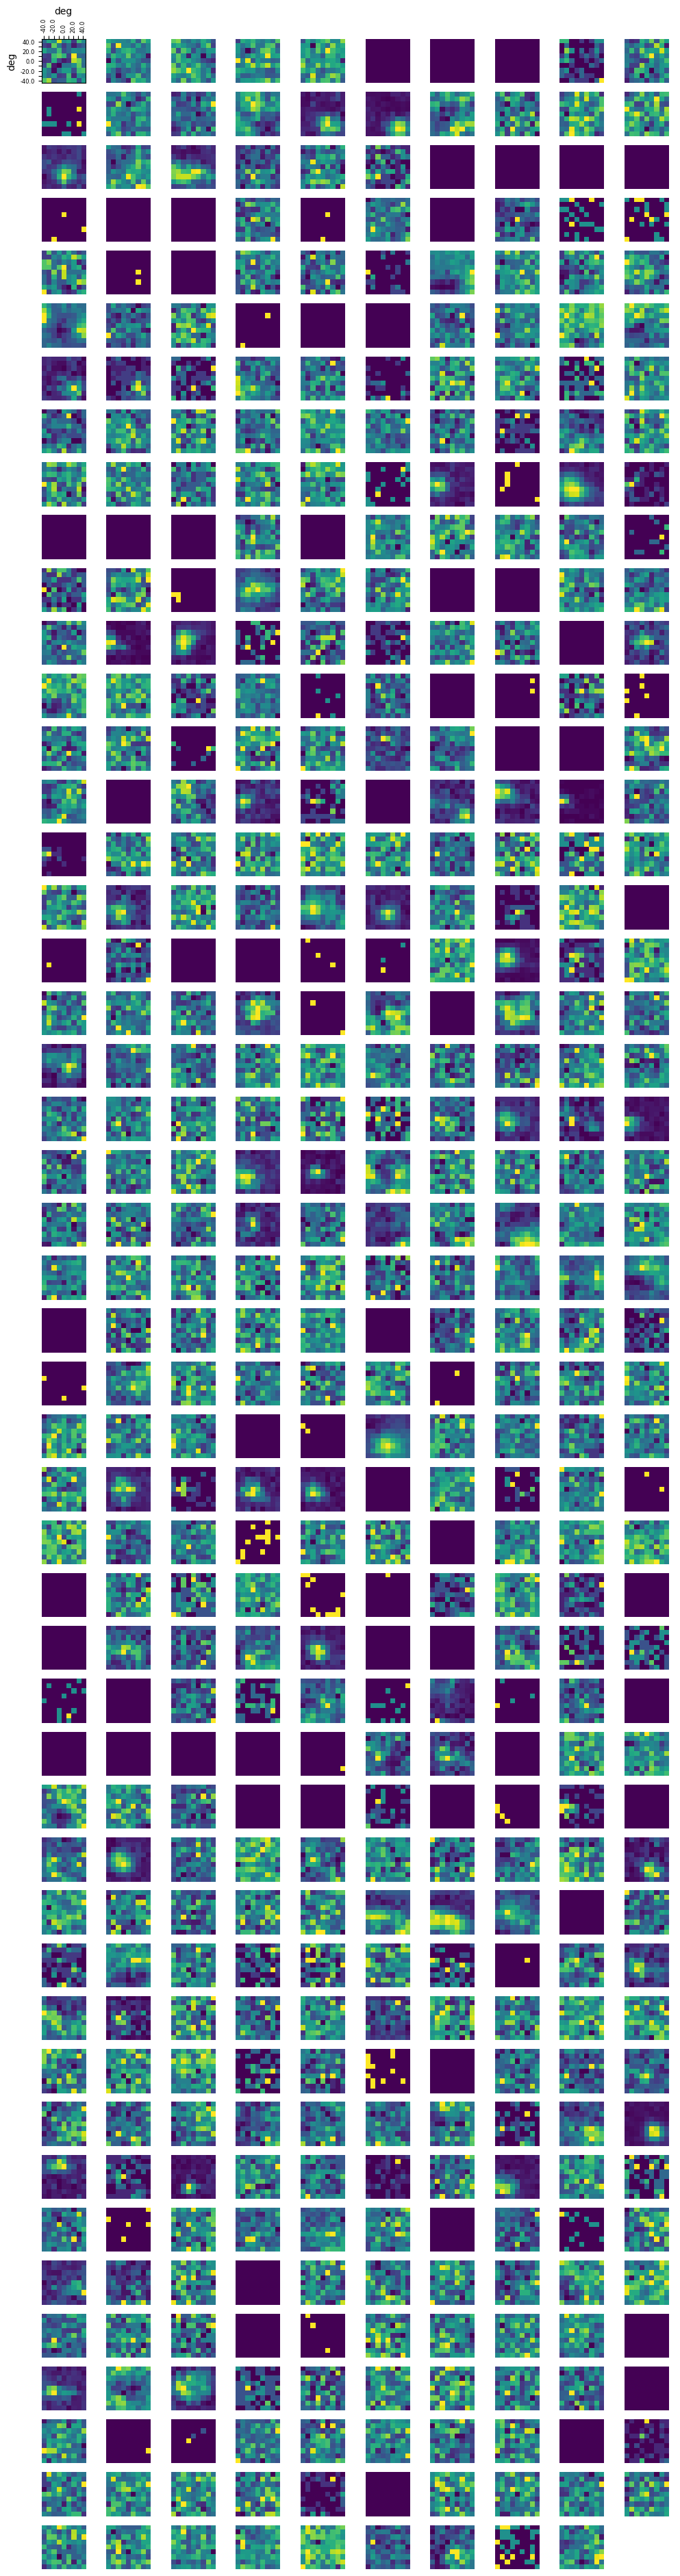

In [15]:
### display the receptive fields for each unit in a 2D plot
#me: takes only certain number of neurons
n_rows = len(unit_rfs)//10
fig, axes = plt.subplots(n_rows+1, 10)
fig.set_size_inches(12, n_rows+1)

# handle case where there's <= 10 rfs
if len(axes.shape) == 1:
    axes = axes.reshape((1, axes.shape[0]))

for irf, rf in enumerate(unit_rfs):
    ax_row = int(irf/10)
    ax_col = irf%10
    axes[ax_row][ax_col].imshow(rf, origin="lower")
for ax in axes.flat[1:]:
    ax.axis('off')

# making axis labels for first receptive field
axes[0][0].set_xlabel(field_units)
axes[0][0].set_ylabel(field_units)
axes[0][0].xaxis.set_label_position("top") 
axes[0][0].xaxis.set_ticks_position("top")
axes[0][0].set_xticks(range(len(xs)), xs, rotation=90, fontsize=6)
axes[0][0].set_yticks(range(len(ys)), ys, fontsize=6)

for i, l in enumerate(axes[0][0].xaxis.get_ticklabels()):
    if i % 2 != 0:
        l.set_visible(False)
for i, l in enumerate(axes[0][0].yaxis.get_ticklabels()):
    if i % 2 != 0:
        l.set_visible(False)

## Plot in cloud

In [16]:
### Plotly with COLOR
import plotly.graph_objects as go
import numpy as np
from PIL import Image
import io
import base64
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Random positions
np.random.seed(42)
n_rfs = len(unit_rfs)
x_positions = np.random.uniform(0, 10, n_rfs)
y_positions = np.random.uniform(0, 10, n_rfs)

fig = go.Figure()

# Add scatter points (clickable)
fig.add_trace(go.Scatter(
    x=x_positions,
    y=y_positions,
    mode='markers',
    marker=dict(size=20, color='lightblue', line=dict(width=1, color='black')),
    text=[f"Unit {i}" for i in range(n_rfs)],
    hoverinfo='text'
))

# Add RF images as layout images with COLOR
for i, (rf, x, y) in enumerate(zip(unit_rfs, x_positions, y_positions)):
    # Normalize RF for display (0-1 range)
    rf_norm = (rf - rf.min()) / (rf.max() - rf.min()) if rf.max() > rf.min() else rf
    
    # Apply colormap (RdBu_r) to get RGB image
    cmap = cm.get_cmap('viridis')  # You can change this: 'viridis', 'plasma', 'hot', etc.
    rf_colored = cmap(rf_norm)  # This returns RGBA
    
    # Convert to uint8 RGB (drop alpha channel)
    rf_uint8 = (rf_colored[:, :, :3] * 255).astype(np.uint8)
    
    # Convert to PIL Image
    img = Image.fromarray(rf_uint8, mode='RGB')
    
    # Convert to base64 string
    buffered = io.BytesIO()
    img.save(buffered, format="PNG")
    img_str = base64.b64encode(buffered.getvalue()).decode()
    
    fig.add_layout_image(
        dict(
            source=f"data:image/png;base64,{img_str}",
            x=x - 0.3,
            y=y + 0.3,
            sizex=0.6,
            sizey=0.6,
            xref="x",
            yref="y",
            opacity=1.0,
            layer="above"
        )
    )

fig.update_layout(
    width=1200,
    height=900,
    xaxis=dict(
        range=[-0.5, 10.5],
        showgrid=False,
        zeroline=False,
        showticklabels=False,  # <-- Hide x tick labels
        visible=False           # <-- Hide x-axis entirely
    ),
    yaxis=dict(
        range=[-0.5, 10.5],
        showgrid=False,
        zeroline=False,
        showticklabels=False,  # <-- Hide y tick labels
        visible=False           # <-- Hide y-axis entirely
    ),
    showlegend=False,
)

fig.show()

## Plot the average

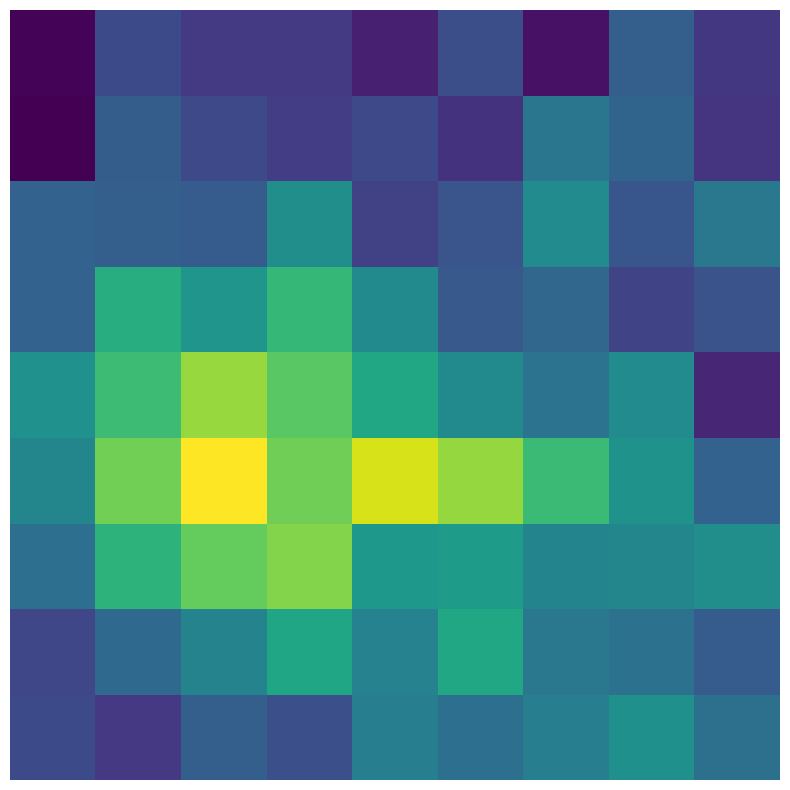

Average RF shape: (9, 9)
Average RF min: 33.4113
Average RF max: 44.1795
Average RF mean: 37.7952


In [17]:
### Plot the AVERAGE receptive field
import numpy as np
import matplotlib.pyplot as plt

# Calculate average RF
average_rf = np.mean(unit_rfs, axis=0)

# Create figure
fig, ax = plt.subplots(figsize=(8, 8))

# Plot average RF with colorbar
im = ax.imshow(average_rf, origin="lower", cmap='viridis')
ax.set_xlabel(field_units)
ax.set_ylabel(field_units)
#ax.set_title(f'Average Receptive Field (n={len(unit_rfs)} units)', fontsize=14)

# Add axis labels
ax.set_xticks(range(len(xs)))
ax.set_xticklabels(xs, rotation=90, fontsize=8)
ax.set_yticks(range(len(ys)))
ax.set_yticklabels(ys, fontsize=8)

# Show every other tick label for clarity
for i, l in enumerate(ax.xaxis.get_ticklabels()):
    if i % 2 != 0:
        l.set_visible(False)
for i, l in enumerate(ax.yaxis.get_ticklabels()):
    if i % 2 != 0:
        l.set_visible(False)

# # Add colorbar
# cbar = plt.colorbar(im, ax=ax)
# cbar.set_label('Average Response', rotation=270, labelpad=20)

ax.axis('off')

plt.tight_layout()
plt.show()

# Optional: Print statistics
print(f"Average RF shape: {average_rf.shape}")
print(f"Average RF min: {average_rf.min():.4f}")
print(f"Average RF max: {average_rf.max():.4f}")
print(f"Average RF mean: {average_rf.mean():.4f}")

In [31]:
# TODO: before filtering with the Gaussian,  filter based on this research paper: Feedback generates a second receptive field in neurons of the visual cortex
#find the center of the heatmap
#check if there are surrounding areas of significant(?) neuronal activation within 10 deg from the center
# if there is more than 1, then include the unit, otherwise exclude

def filter_heatmaps(unit_idx):
    pass

## Gaussian Smoothing and R^2 computation

In [18]:
#gaussian smoothing
from scipy.ndimage import gaussian_filter

#print(type(unit_rfs[0][0][0]))

def smoothing_rf(rf_list, s):
    """returns smoothed list of rfs (Gaussian smoothing)
    rf_list is a list of receptive fields
    s is the standard deviation for the model>"""
    smooth_rfs = []
    for rf in unit_rfs: 
        #adjust sigma (stdev) for more/less smoothing
        smooth_rf = gaussian_filter(rf, sigma = s)
        smooth_rfs.append(smooth_rf)
    return smooth_rfs

Functions for computing the Gaussian

In [19]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import pearsonr

def gaussian_2d(coords, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    """2D Gaussian function"""
    x, y = coords
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) + c*((y-yo)**2)))
    return g.ravel()

def fit_gaussian_to_rf(rf):
    
    # Create coordinate arrays
    x = np.arange(rf.shape[1])
    y = np.arange(rf.shape[0])
    x, y = np.meshgrid(x, y)
    
    # Initial guess for parameters
    amplitude_guess = rf.max() - rf.min()
    xo_guess = rf.shape[1] / 2
    yo_guess = rf.shape[0] / 2
    sigma_guess = min(rf.shape) / 4
    
    initial_guess = (amplitude_guess, xo_guess, yo_guess, sigma_guess, sigma_guess, 0, rf.min())
    
    try:
        # Fit the Gaussian
        popt, pcov = curve_fit(
            gaussian_2d, 
            (x, y), 
            rf.ravel(), 
            p0=initial_guess,
            maxfev=10000
        )
        
        # Calculate fitted RF
        fitted_rf = gaussian_2d((x, y), *popt).reshape(rf.shape)
        
        # Calculate R-squared
        ss_res = np.sum((rf.ravel() - fitted_rf.ravel())**2)
        ss_tot = np.sum((rf.ravel() - np.mean(rf.ravel()))**2)
        r_squared = 1 - (ss_res / ss_tot)
        
        return popt, r_squared, fitted_rf
        
    except Exception as e:
        print(f"Fitting failed: {e}")
        return None, 0.0, None

def filter_rfs_by_gaussian_fit(unit_rfs, r_squared_threshold=0.5, verbose=False):

    filtered_rfs = []
    filtered_indices = []
    r_squared_values = []
    fitted_rfs = []
    
    for i, rf in enumerate(unit_rfs):
        popt, r_squared, fitted_rf = fit_gaussian_to_rf(rf)
        r_squared_values.append(r_squared)
        
        if r_squared >= r_squared_threshold:
            filtered_rfs.append(rf)
            filtered_indices.append(i)
            fitted_rfs.append(fitted_rf)
    
    if verbose:
        print(f"Gaussian fitting results:")
        print(f"  Total units: {len(unit_rfs)}")
        print(f"  Passed filter (R² >= {r_squared_threshold}): {len(filtered_rfs)}")
        print(f"  Rejected: {len(unit_rfs) - len(filtered_rfs)}")
        print(f"  Mean R²: {np.mean(r_squared_values):.3f}")
        print(f"  Median R²: {np.median(r_squared_values):.3f}")
        print(f"  Min R²: {np.min(r_squared_values):.3f}")
        print(f"  Max R²: {np.max(r_squared_values):.3f}")
    
    return filtered_rfs, filtered_indices, r_squared_values, fitted_rfs


Computing the r^2 values for all receptive fields

In [20]:
def r_squared_values(unit_rfs):
    """Returns the r^2 values of all receptive fields"""
    r_squared_vals = []
    for rf in unit_rfs:
        _, r_squared, _ = fit_gaussian_to_rf(rf)
        r_squared_vals.append(r_squared)
    return r_squared_vals

In [26]:
import math

def plot_sorted_receptive_fields(unit_rfs, save_dir,  r2_values, version_name):
    """
    Plots all receptive fields sorted by R² (descending), saves PNG to probe folder.
    """
    os.makedirs(save_dir, exist_ok=True)
    # Pair RF with its R² and sort (best first)
    rf_r2_pairs = list(zip(unit_rfs, r2_values, range(len(unit_rfs))))

    #drop NaN r^2 values and corresponding rfs
    rf_r2_pairs = [pair for pair in rf_r2_pairs if not math.isnan(pair[1])]

    #sorting rfs in descending oredr based on r^2 values 
    rf_r2_pairs.sort(key=lambda x: x[1], reverse=True)

    num_rfs = len(rf_r2_pairs)
    cols = 10
    rows = math.ceil(num_rfs / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(3*cols, 3*rows))
    axes = axes.flatten()

    for ax, (rf, r2, idx) in zip(axes, rf_r2_pairs):
        ax.imshow(rf, origin="lower", cmap="viridis")
        ax.set_title(f"Unit {idx} | R² = {r2:.2f}", fontsize=9)
        ax.axis("off")

    # Hide empty axes
    # for ax in axes[num_rfs:]:
    #     ax.axis("off")
    fig.suptitle(f" {version_name}", fontsize=16)
    plt.tight_layout()

    save_path = os.path.join(save_dir, f"{version_name}_sorted_rfs.png")
    plt.savefig(save_path, dpi=150)
    plt.close(fig)

    plt.close(fig)


In [27]:
#smooth the receptive fields
#compute r^2 values for all non-smoothed receptive fields
#compute r^2 values for all smoothed receptive fields
#visualize sorted smoothed receptive fields and save the image
#visualize sorted non-smoothed receptive fields and save the image
# filter receptive fields based on r^2 threshold for both smoothed and non-smoothed
#save both filtered versions of the receptive fields

 
smoothed_rfs = smoothing_rf(unit_rfs, 1.0)
r2_values_unsmoothed = r_squared_values(unit_rfs)
r2_values_smoothed = r_squared_values(smoothed_rfs)

plot_sorted_receptive_fields(unit_rfs, "probeB_results", r2_values_unsmoothed, "unsmoothed_probeB")
plot_sorted_receptive_fields(smoothed_rfs, "probeB_results", r2_values_smoothed, "smoothed_probeB")

filtered_rfs_unsmoothed, filtered_indices_unsmoothed, r_squared_vals_unsmoothed, fitted_rfs_unsmoothed = filter_rfs_by_gaussian_fit(unit_rfs, r_squared_threshold=0.5, verbose=True)

filtered_rfs_smoothed, filtered_indices_smoothed, r_squared_vals_smoothed, fitted_rfs_smoothed = filter_rfs_by_gaussian_fit(smoothed_rfs, r_squared_threshold=0.5, verbose=True)

plot_sorted_receptive_fields(filtered_rfs_smoothed, "probeB_filtered_results", r_squared_vals_smoothed, "smoothed_filtered_probeB")
# Save filtered receptive fields and their indices
plot_sorted_receptive_fields(filtered_rfs_unsmoothed, "probeB_filtered_results", r_squared_vals_unsmoothed, "unsmoothed_filtered_probeB")



Fitting failed: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Fitting failed: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Fitting failed: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Fitting failed: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Fitting failed: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Fitting failed: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Fitting failed: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Fitting failed: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Fitting failed: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Fitting failed: Optimal parameters not found: Number of calls to function has reac

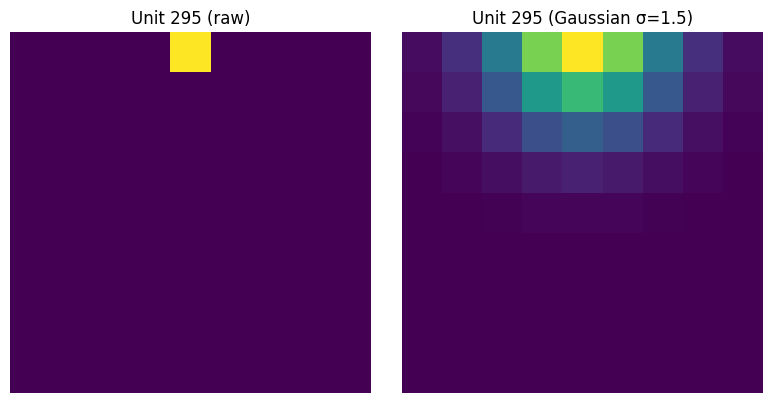

In [28]:
#trying to plot only one unit smothed vs unsmoothed
rf = unit_rfs[295]
rf_smoothed = gaussian_filter(rf, 1.5)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].imshow(rf, origin="lower", cmap="viridis")
axes[0].set_title("Unit 295 (raw)")
axes[0].axis("off")

axes[1].imshow(rf_smoothed, origin="lower", cmap="viridis")
axes[1].set_title(f"Unit 295 (Gaussian σ={1.5})")
axes[1].axis("off")

plt.tight_layout()
plt.show()